## Day2 （環境から計画を立てる）

ここでは動的計画法(Dynamic　Programing: DP)を扱う。


In [1]:
import random
import sys
sys.path.append('../../baby-steps-of-rl-ja/DP/')

from environment import Environment

## Day1復習

- 強化学習はマルコフ決定過程を仮定し、その元で報酬の総和を最大化する方策をもつエージェントをもとめる問題
    - マルコフ決定過程は以下の(S, A, T, R)の組である
        - S: 状態全体の集合
        - A: アクション全体の集合
        - T: S×A×S -> [0, 1] 状態とアクションから次の状態への遷移確率を返す関数
        - R: S×A×S -> 実数全体 状態, アクション, 遷移状態の状態から報酬を返す関数


- Environmentクラス
    - 迷路環境クラス
    - State, Actionを内部に持つ
    - Environment.step()メソッドにアクションを渡すことで、内部で遷移確率T(s'| s, a)を計算し、Tに応じた(状態遷移/rewardの計算/終了判定)をする。

# Bellman方程式
- 価値評価関数を網羅的に、厳密に計算する例
- Value baseのiteration実装
- Policy baseのiteration実装

- policy baseのアクションは確率1/0しかないのか?（実装はそうなっている）　policyで複数アクションが等確率になった場合の計算方法は？

## Bellman方程式の計算(決定的)
- 価値関数の再帰表現を用いた価値計算
- 状態数が多くない & エピソードが長くない場合に計算可能

In [2]:
# happy endゲーム(仮)
# upかdownを繰り返し、5回行動したら終了。終了時upがHAPPY_END_BORDER以上なら"happy_end", そうでなければ"bad_end"
# MOVE


def V(s, gamma=0.99):
    """ 価値関数(再帰)
    次の状態の(遷移確率 * 価値)のmaxのみを計算に使用
    """
    V = R(s) + gamma * max_V_on_next_state(s)
    return V


def R(s):
    """ 報酬関数
    終了状態のみ±1, それ以外0
    """
    if s == "happy_end":
        return 1
    elif s == "bad_end":
        return -1
    else:
        return 0


def max_V_on_next_state(s):
    """ 
    全アクション, 全遷移先状態の(遷移確率 * 価値)のmaxの値を返す
    """
    # If game end, expected value is 0.
    if s in ["happy_end", "bad_end"]:
        return 0

    actions = ["up", "down"]
    values = []
    for a in actions:
        transition_probs = transit_func(s, a)
        v = 0
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            v += prob * V(next_state)
        values.append(v)
    return max(values)


def transit_func(s, a):
    """ T(s'| s, a): 状態とアクション("up", "down")を受け取り、遷移確率を返す
    Make next state by adding action str to state.
    ex: (s = 'state', a = 'up') => 'state_up'
        (s = 'state_up', a = 'down') => 'state_up_down'
    """

    actions = s.split("_")[1:]
    LIMIT_GAME_COUNT = 5
    HAPPY_END_BORDER = 4
    MOVE_PROB = 0.9

    def next_state(state, action):
        return "_".join([state, action])

    # ゲーム終了, 確率1で終了結果　に遷移
    if len(actions) == LIMIT_GAME_COUNT:
        up_count = sum([1 if a == "up" else 0 for a in actions])
        state = "happy_end" if up_count >= HAPPY_END_BORDER else "bad_end"
        prob = 1.0
        return {state: prob}
    # ゲーム続行
    else:
        opposite = "up" if a == "down" else "down"
        return {
            next_state(s, a): MOVE_PROB,
            next_state(s, opposite): 1 - MOVE_PROB
        }


In [3]:
# 状態価値の算出
print(V("state"))
print(V("state_up_up"))
print(V("state_down_down"))

0.7880942034605892
0.9068026334400001
-0.96059601


## Bellman方程式の計算(動的計画法近似)

## planner
- 動的計画法による価値関数近似クラス
- Plannerクラスを継承してValueIterationとPolicyIterationクラスを実装

In [4]:
class Planner():

    def __init__(self, env):
        self.env = env
        self.log = []

    def initialize(self):
        self.env.reset()
        self.log = []

    def plan(self, gamma=0.9, threshold=0.0001):
        raise Exception("Planner have to implements plan method.")

    def transitions_at(self, state, action):
        transition_probs = self.env.transit_func(state, action)
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            reward, _ = self.env.reward_func(next_state)
            yield prob, next_state, reward

    def dict_to_grid(self, state_reward_dict):
        grid = []
        for i in range(self.env.row_length):
            row = [0] * self.env.column_length
            grid.append(row)
        for s in state_reward_dict:
            grid[s.row][s.column] = state_reward_dict[s]

        return grid

## Value Iteration

In [5]:
class ValueIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)

    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        actions = self.env.actions
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0
            
        i = 0
        while True:
            i += 1
            print(f'ite: {i}')
            delta = 0
            self.log.append(self.dict_to_grid(V))
            for s in V:
                if not self.env.can_action_at(s):
                    continue
                expected_rewards = []
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                delta = max(delta, abs(max_reward - V[s]))
                V[s] = max_reward

            if delta < threshold:
                break

        V_grid = self.dict_to_grid(V)
        return V_grid

## Policy Iteration 

In [6]:
class PolicyIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)
        self.policy = {}

    def initialize(self):
        super().initialize()
        self.policy = {}
        actions = self.env.actions
        states = self.env.states
        for s in states:
            self.policy[s] = {}
            for a in actions:
                # Initialize policy.
                # At first, each action is taken uniformly.
                self.policy[s][a] = 1 / len(actions)

    def estimate_by_policy(self, gamma, threshold):
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0
    

        while True:
            delta = 0
            for s in V:
                expected_rewards = []
                for a in self.policy[s]:
                    action_prob = self.policy[s][a]
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += action_prob * prob * \
                             (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                value = sum(expected_rewards)
                delta = max(delta, abs(value - V[s]))
                V[s] = value
            if delta < threshold:
                break

        return V

    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        states = self.env.states
        actions = self.env.actions

        def take_max_action(action_value_dict):
            return max(action_value_dict, key=action_value_dict.get)

        i = 0
        while True:
            i += 1
            print(f'ite: {i}')
            update_stable = True
            # Estimate expected rewards under current policy.
            V = self.estimate_by_policy(gamma, threshold)
            self.log.append(self.dict_to_grid(V))

            for s in states:
                # Get an action following to the current policy.
                policy_action = take_max_action(self.policy[s])

                # Compare with other actions.
                action_rewards = {}
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    action_rewards[a] = r
                best_action = take_max_action(action_rewards)
                if policy_action != best_action:
                    update_stable = False

                # Update policy (set best_action prob=1, otherwise=0 (greedy))
                for a in self.policy[s]:
                    prob = 1 if a == best_action else 0
                    self.policy[s][a] = prob

            if update_stable:
                # If policy isn't updated, stop iteration
                break

        # Turn dictionary to grid
        V_grid = self.dict_to_grid(V)
        return V_grid

## 可視化

In [7]:
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

def show_grid_value(val: List):
    sns.heatmap(val, annot=True)

# Make grid environment.
grid = [
    [0, 0, 0, 1],
    [0, 9, 0, -1],
    [0, 0, 0, 0]
]
env = Environment(grid)

ite: 1
ite: 2
ite: 3
ite: 4
ite: 5
ite: 6
ite: 7
ite: 8
ite: 9
ite: 10
ite: 11


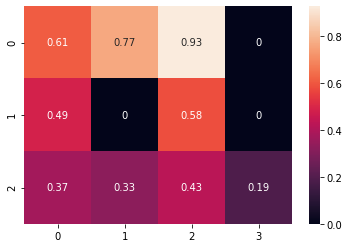

In [8]:
value_planner = ValueIterationPlanner(Environment(grid))

show_grid_value(value_planner.plan())

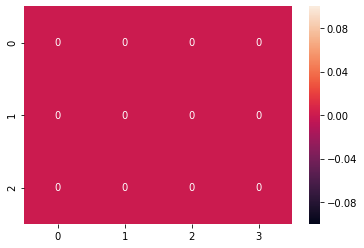

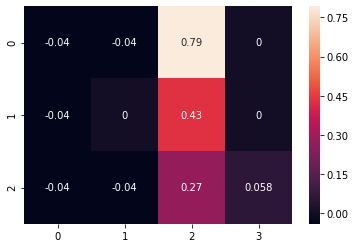

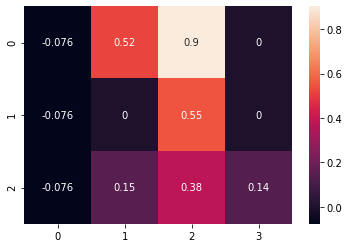

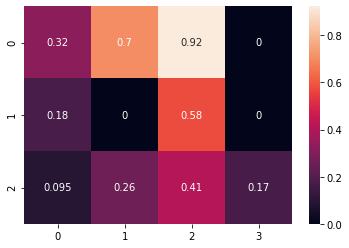

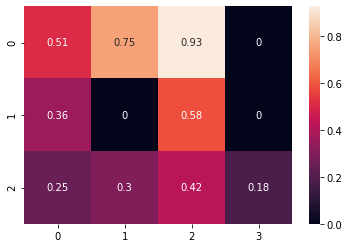

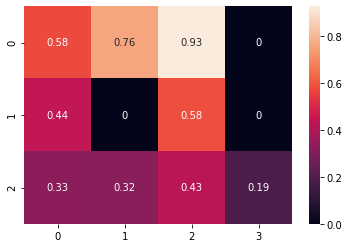

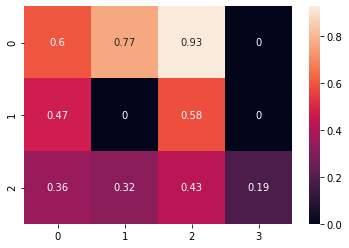

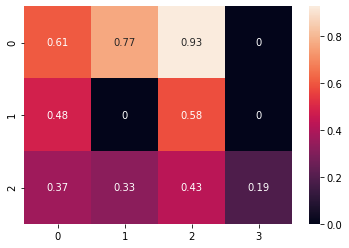

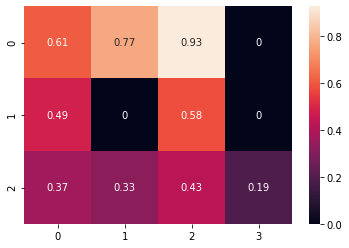

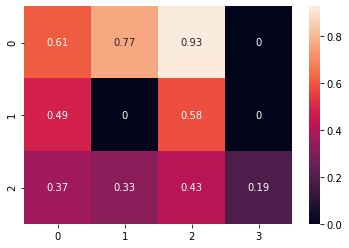

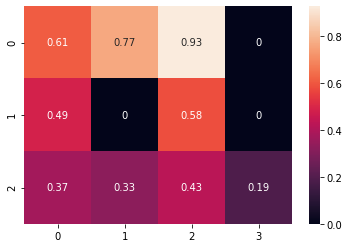

In [9]:
# log確認
for i, v_s in enumerate(value_planner.log):
    plt.figure(i)
    show_grid_value(v_s)

ite: 1
ite: 2
ite: 3
ite: 4


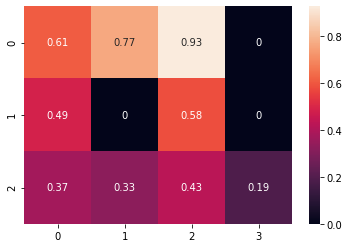

In [10]:
policy_planner = PolicyIterationPlanner(Environment(grid))

show_grid_value(policy_planner.plan())

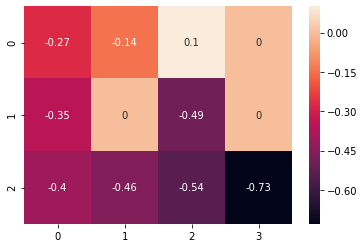

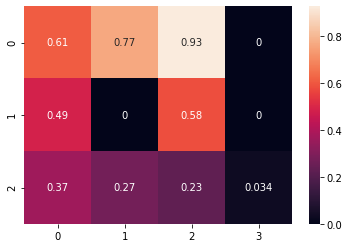

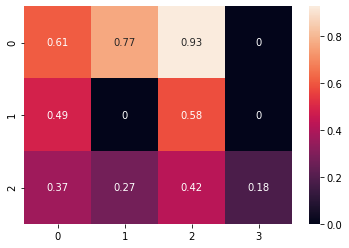

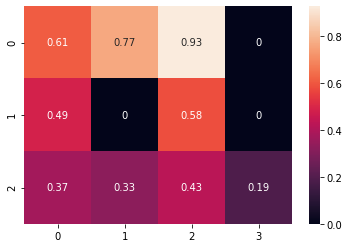

In [11]:
# log確認
for i, v_s in enumerate(policy_planner.log):
    plt.figure(i)
    show_grid_value(v_s)

# TODO
- policy/value iterationの証明
1. Bellman方程式の作用素表現 （value base, policy base）
1. 関数空間V上一様ノルムを入れた際の縮小写像証明 （maxとminを計算して上としたから抑える）
1. {T^nv}がcauchy列である証明（三角不等式と縮小写像）
1. （存在性）(距離空間の完備性より、{T^nv}は収束列で収束先v* :=lim_{n \to \infty}{T^nv}が存在)
1. Tv* =v*  の証明（「Tが縮小写像 => リプシッツ連続 => 連続関数」よりlimitの順状交換可能、ε-nから直接、など）
1. 任意の初期値v_0に対し、v* :=lim_{n \to \infty}{T^nv_0}の証明（2.と5.を複数回使用することで距離が0になる）
1. (一意性)一意性の証明もやる（v* 1, v* 2の距離をとって、Tで一回飛ばすとv* 1=v* 2以外矛盾）

上記より (value/policy)iterationによる近似が正当化される

関数空間Vの一様ノルムによる完備性は課題...

## happy endゲームの環境実装
- Value/Policy iterationを行えるようにhappy endゲームの環境クラスを実装する
- 迷路のStateをはridで表現していたが、happy_endゲームは5次元空間になるためリスト表現する、可視化は工夫

In [12]:
from enum import Enum
import numpy as np


class Action(Enum):
    UP = 1
    DOWN = -1

# .reset(), .transit_func(), .reward_func(),が同じならOK
class HappyEndEnvironment():

    def __init__(self, n_max: int, happy_end_border: int, move_prob=0.8):
        """
        n: 終了回数
        move_prob: アクションと同方向へ遷移する確率
        """
        self.n_max = n_max
        self.border = happy_end_border
        self.agent_state = "state"
        self.move_prob = move_prob
        self.reset()

    @property
    def actions(self):
        return [Action.UP, Action.DOWN]
    
    @property
    def states(self):
        """環境が取りうる終了状態以外の全状態集合
            plannerで値を更新する対象状態となる
            
        """
        state_space = ['happy_end', 'bad_end']
        def add_state(state, n):
            state_space.append(state)
            if n > 0:
                for a in ['up', 'down']:
                    new_state = state + '_' + a
                    add_state(new_state, n-1)
        
        add_state('state', self.n_max)
        return state_space

    
    def transit_func(self, state, action):
        def next_state(s, a):
            
            return "_".join([s, "up" if a == Action.UP else "down"])
        
        past_moves = state.split("_")[1:]
        
        if state in ["happy_end", "bad_end"]:
            return {}
        elif len(past_moves) == self.n_max:
            up_count = sum([1 if a == "up" else 0 for a in past_moves])
            state = "happy_end" if up_count >= self.border else "bad_end"
            prob = 1.0
            return {state: prob}
        else:
            opposite = Action(action.value * -1)
            return {
                next_state(state, action): self.move_prob,
                next_state(state, opposite): 1 - self.move_prob
            }


    def reward_func(self, state):
        past_moves = state.split("_")[1:] 
        if state == "happy_end":            
            reward, done = 1, True
        elif state == "bad_end":            
            reward, done = -1,  True
        else:
            reward, done = 0, False
        return reward, done

    
    def reset(self):
        self.agent_state = "state"
        return self.agent_state

    
    def step(self, action):
        next_state, reward, done = self.transit(self.agent_state, action)
        if next_state is not None:
            self.agent_state = next_state
        return next_state, reward, done

    
    def transit(self, state, action):
        transition_probs = self.transit_func(state, action)
        if len(transition_probs) == 0:
            return None, None, True
        next_states = []
        probs = []
        for s in transition_probs:
            next_states.append(s)
            probs.append(transition_probs[s])

        next_state = np.random.choice(next_states, p=probs)
        reward, done = self.reward_func(next_state)
        return next_state, reward, done


In [13]:
# test, random Agent
class Agent():
    # initで入力した環境のactionをランダムに出力する。

    def __init__(self, env):
        self.actions = env.actions

    def policy(self, state):
        return random.choice(self.actions)

# Make grid environment.
env = HappyEndEnvironment(n_max=5, happy_end_border=3, move_prob=0.8)
agent = Agent(env)

# Try 10 game.
for i in range(10):
    # Initialize position of agent.
    state = env.reset()
    total_reward = 0
    done = False

    while True:
        action = agent.policy(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        if done:
            # 終了一個前状態を表示するためにbreak処理をここにはさむ
            print(state)
            break
        state = next_state
    
    print("Episode {}: Agent gets {} reward.\n".format(i, total_reward))

state_down_up_down_down_down
Episode 0: Agent gets -1 reward.

state_up_down_down_down_down
Episode 1: Agent gets -1 reward.

state_up_down_up_down_down
Episode 2: Agent gets -1 reward.

state_up_down_down_up_up
Episode 3: Agent gets 1 reward.

state_up_down_down_up_up
Episode 4: Agent gets 1 reward.

state_up_down_up_down_up
Episode 5: Agent gets 1 reward.

state_down_down_down_down_down
Episode 6: Agent gets -1 reward.

state_up_up_down_down_up
Episode 7: Agent gets 1 reward.

state_up_down_up_down_down
Episode 8: Agent gets -1 reward.

state_up_down_down_down_up
Episode 9: Agent gets -1 reward.



# planner書き換え
- dict_to_gridが迷路固有のものなので、happy endゲーム用に書き換え
    - 単なるログ/出力用？　親クラスのdict_to_gridに触らずに辞書のままログを保存, 出力するように書き換え
    - そもそもログ/出力をstateキーの辞書で持っておいた方がいろいろな環境に対応できるのでは、、、
    - 環境固有の状態変換メソッドを親クラスにもつと良くなさそう

In [14]:
def get_happyend_states(n):
    state_space = []

    def add_action(state, n):
        state_space.append(state)
        if n > 0:
            for a in ['up', 'down']:
                new_state = state + '_' + a
                add_action(new_state, n-1)

    add_action('state', n)
    return state_space

In [15]:
# 全状態空間が必要, 大きくなると大変なことに...
get_happyend_states(3)

['state',
 'state_up',
 'state_up_up',
 'state_up_up_up',
 'state_up_up_down',
 'state_up_down',
 'state_up_down_up',
 'state_up_down_down',
 'state_down',
 'state_down_up',
 'state_down_up_up',
 'state_down_up_down',
 'state_down_down',
 'state_down_down_up',
 'state_down_down_down']

# policy/value iteration planner(汎用)

In [16]:
class Planner():
    def __init__(self, env):
        self.env = env
        self.log = []

    def initialize(self):
        self.env.reset()
        self.log = []

    def plan(self, gamma=0.9, threshold=0.0001):
        raise Exception("Planner have to implements plan method.")

    def transitions_at(self, state, action):
        # is_terminal追加
        transition_probs = self.env.transit_func(state, action)
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            reward, _ = self.env.reward_func(next_state)
            yield prob, next_state, reward

            
class ValueIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)

    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        actions = self.env.actions
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0
        i = 0
        while True:
            i += 1
            print(f'ite: {i}')
            delta = 0
            self.log.append(V)
            for s in V:
                # 到達できない場所 or 終着点の場合、計算を無視
                # そもそも状態空間に含めなければ良いのでは？ そもそもtransitin_probで移動を制限してるので必要なくない？, 確率1で終端地点に到達し、rewardをちゃんと設定できていればよさそう
                # if not self.env.can_action_at(s):
                #     continue
                expected_rewards = []
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    # 各アクション毎の遷移先価値期待値のmaxを考える
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                delta = max(delta, abs(max_reward - V[s]))
                V[s] = max_reward

            if delta < threshold:
                break
        return V
    
    
class PolicyIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)
        self.policy = {}

    def initialize(self):
        super().initialize()
        self.policy = {}
        actions = self.env.actions
        states = self.env.states
        for s in states:
            self.policy[s] = {}
            for a in actions:
                # Initialize policy.
                # At first, each action is taken uniformly.
                self.policy[s][a] = 1 / len(actions)

    def estimate_by_policy(self, gamma, threshold):
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0
            
        i = 0
        while True:
            i += 1
            print(f'ite: {i}')
            delta = 0
            for s in V:
                expected_rewards = []
                for a in self.policy[s]:
                    action_prob = self.policy[s][a]
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += action_prob * prob * \
                             (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                value = sum(expected_rewards)
                delta = max(delta, abs(value - V[s]))
                V[s] = value
            if delta < threshold:
                break
        return V

    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        states = self.env.states
        actions = self.env.actions

        def take_max_action(action_value_dict):
            return max(action_value_dict, key=action_value_dict.get)

        while True:
            print(f'ite: {i}')
            update_stable = True
            # Estimate expected rewards under current policy.
            V = self.estimate_by_policy(gamma, threshold)
            self.log.append(V)

            for s in states:
                # Get an action following to the current policy.
                policy_action = take_max_action(self.policy[s])

                # Compare with other actions.
                action_rewards = {}
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    action_rewards[a] = r
                best_action = take_max_action(action_rewards)
                if policy_action != best_action:
                    update_stable = False

                # Update policy (set best_action prob=1, otherwise=0 (greedy))
                for a in self.policy[s]:
                    prob = 1 if a == best_action else 0
                    self.policy[s][a] = prob

            if update_stable:
                # If policy isn't updated, stop iteration
                # DEBUG: print(policy_action)
                break
        return V

In [17]:
def show_happyend_value(state_value_dict):
    """happy endゲームの価値関数辞書を可視化する関数"""
    # value順にsort
    len_max = max([len(x) for x in state_value_dict.keys()])
    print('\nValue function of HappyEndGame states:')
    print('-' * (len_max + 16))
    print('|  |state'.ljust(len_max) + '|' + 'value'.ljust(14) + '|')
    print('-' * (len_max + 16))
    for state, val in sorted(state_value_dict.items(), key=lambda i: i[1]):
        _state = (
            state
            .replace('bad_end', '|T | BAD_END')
            .replace('happy_end', '|T | HAPPY_END')
            .replace('state', '|S |')
            .replace('S |_', 'S | ')
            .replace('up', '  UP ')
            .replace('down', 'DOWN ')
            .replace('_', '')
        )
        print(_state.ljust(len_max) + '|' + '{:.4g}'.format(val).rjust(14) + '|')
    print('-' * (len_max + 16))

- 冒頭の比較対象

In [18]:
# gamma 0.99
# LIMIT_GAME_COUNT = 5
# HAPPY_END_BORDER = 4
# MOVE_PROB = 0.9


print(V("state"))
print(V("state_up_up"))
print(V("state_down_down"))

0.7880942034605892
0.9068026334400001
-0.96059601


In [19]:
value_planner = ValueIterationPlanner(
    HappyEndEnvironment(
        n_max=5,
        happy_end_border=4,
        move_prob=0.9
    )
)
V_value = value_planner.plan(gamma=0.99, threshold=0.000001)

ite: 1
ite: 2
ite: 3
ite: 4
ite: 5
ite: 6
ite: 7


In [20]:
print(V_value["state"])
print(V_value["state_up_up"])
print(V_value["state_down_down"])

0.7960547509702921
0.9159622560000001
-0.9702989999999999


In [21]:
show_happyend_value(V_value)


Value function of HappyEndGame states:
----------------------------------------------
|  |state                     |value         |
----------------------------------------------
|S |   UP   UP   UP DOWN DOWN |            -1|
|S |   UP   UP DOWN   UP DOWN |            -1|
|S |   UP   UP DOWN DOWN   UP |            -1|
|S |   UP   UP DOWN DOWN DOWN |            -1|
|S |   UP DOWN   UP   UP DOWN |            -1|
|S |   UP DOWN   UP DOWN   UP |            -1|
|S |   UP DOWN   UP DOWN DOWN |            -1|
|S |   UP DOWN DOWN   UP   UP |            -1|
|S |   UP DOWN DOWN   UP DOWN |            -1|
|S |   UP DOWN DOWN DOWN   UP |            -1|
|S |   UP DOWN DOWN DOWN DOWN |            -1|
|S | DOWN   UP   UP   UP DOWN |            -1|
|S | DOWN   UP   UP DOWN   UP |            -1|
|S | DOWN   UP   UP DOWN DOWN |            -1|
|S | DOWN   UP DOWN   UP   UP |            -1|
|S | DOWN   UP DOWN   UP DOWN |            -1|
|S | DOWN   UP DOWN DOWN   UP |            -1|
|S | DOWN   UP DOWN 

In [22]:
# log確認
# for i, v_s in enumerate(value_planner.log):
#     print('ite:', i)
#     show_happyend_value(v_s)

In [23]:
policy_planner = PolicyIterationPlanner(
    HappyEndEnvironment(
        n_max=5,
        happy_end_border=4,
        move_prob=0.9
    )
)

V_policy = policy_planner.plan(gamma=0.99)

ite: 9
ite: 1
ite: 2
ite: 3
ite: 4
ite: 5
ite: 6
ite: 7


In [24]:
# 何かがおかしい

print(V_policy["state"])
print(V_policy["state_up_up"])
print(V_policy["state_down_down"])

-0.5943687811874998
0.0
-0.9702989999999999


In [25]:
show_happyend_value(V_policy)


Value function of HappyEndGame states:
----------------------------------------------
|  |state                     |value         |
----------------------------------------------
|S |   UP   UP   UP DOWN DOWN |            -1|
|S |   UP   UP DOWN   UP DOWN |            -1|
|S |   UP   UP DOWN DOWN   UP |            -1|
|S |   UP   UP DOWN DOWN DOWN |            -1|
|S |   UP DOWN   UP   UP DOWN |            -1|
|S |   UP DOWN   UP DOWN   UP |            -1|
|S |   UP DOWN   UP DOWN DOWN |            -1|
|S |   UP DOWN DOWN   UP   UP |            -1|
|S |   UP DOWN DOWN   UP DOWN |            -1|
|S |   UP DOWN DOWN DOWN   UP |            -1|
|S |   UP DOWN DOWN DOWN DOWN |            -1|
|S | DOWN   UP   UP   UP DOWN |            -1|
|S | DOWN   UP   UP DOWN   UP |            -1|
|S | DOWN   UP   UP DOWN DOWN |            -1|
|S | DOWN   UP DOWN   UP   UP |            -1|
|S | DOWN   UP DOWN   UP DOWN |            -1|
|S | DOWN   UP DOWN DOWN   UP |            -1|
|S | DOWN   UP DOWN 